In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
import numpy as np

In [2]:
def create_oracle(case):
    """
    Creates a Black Box (Oracle) circuit.
    Args:
        case (str): 'constant' or 'balanced'
    Returns:
        Gate: The oracle wrapped as a quantum gate.
    """
    oracle_qc = QuantumCircuit(2)
    
    if case == 'constant':
        # Scenario 1: Output is always 0 (Do nothing)
        # Scenario 2: Output is always 1 (Apply X to qubit 1)
        # We randomly pick one to make it a mystery
        if np.random.randint(2) == 1:
            oracle_qc.x(1)
            
    elif case == 'balanced':
        # Scenario 1: f(x) = x (CNOT gate)
        # Scenario 2: f(x) = NOT x (CNOT wrapped with X)
        # We use CNOT as the core mechanism for balanced functions
        oracle_qc.cx(0, 1)
        
        # Randomly flip output to vary the function
        if np.random.randint(2) == 1:
            oracle_qc.x(1)
            
    # Convert circuit to a Gate instruction
    return oracle_qc.to_gate(label="Oracle (" + case + ")")

print("Oracle Factory ready!")

Oracle Factory ready!


In [3]:
def deutsch_algorithm(oracle_gate):
    """
    Runs Deutsch's Algorithm to determine if the oracle is Constant or Balanced.
    """
    # 1. Initialize: 2 Qubits, 1 Classical Bit
    # q0: Input qubit (Data)
    # q1: Helper qubit (Ancilla)
    qc = QuantumCircuit(2, 1)
    
    # 2. State Preparation
    # q1 needs to be in state |-> for Phase Kickback to work
    qc.x(1)      # q1 -> |1>
    qc.h(1)      # q1 -> |-> (superposition with negative phase)
    
    # q0 needs to be in state |+> to query all inputs at once
    qc.h(0)      # q0 -> |+>
    
    qc.barrier()
    
    # 3. Query the Oracle (The Black Box)
    qc.append(oracle_gate, [0, 1])
    
    qc.barrier()
    
    # 4. Interference & Measurement
    # Apply Hadamard to q0 to interfere the phases
    qc.h(0)
    
    # Measure q0 into classical bit 0
    qc.measure(0, 0)
    
    return qc

print("Deutsch Algorithm function defined.")

Deutsch Algorithm function defined.


Measurement Result: {'1': 1024}
=> Conclusion: The function is BALANCED.
=> (Prediction match: True)


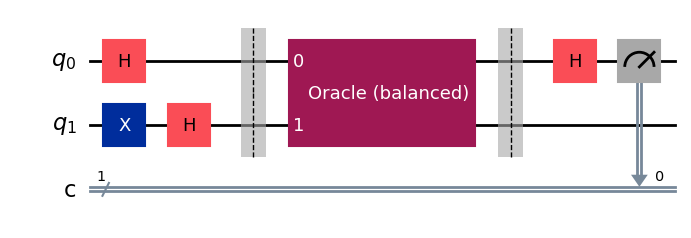

In [4]:
# --- TEST THE ALGORITHM ---

# 1. Pick a secret function type ('constant' or 'balanced')
secret_case = 'balanced' 
oracle = create_oracle(secret_case)

# 2. Build the algorithm circuit
qc = deutsch_algorithm(oracle)

# 3. Run simulation
backend = AerSimulator()
qc_transpiled = transpile(qc, backend)
result = backend.run(qc_transpiled, shots=1024).result()
counts = result.get_counts()

# 4. Analyze results
print(f"Measurement Result: {counts}")

# Logic:
# If we measure '0' -> The function is Constant
# If we measure '1' -> The function is Balanced
if '0' in counts:
    print("=> Conclusion: The function is CONSTANT.")
    print("=> (Prediction match: " + str(secret_case == 'constant') + ")")
else:
    print("=> Conclusion: The function is BALANCED.")
    print("=> (Prediction match: " + str(secret_case == 'balanced') + ")")

# Visualize
qc.draw('mpl')